# <font  color = "#0093AF"> Paramagnetic Effects: Pseudo-Contact Shift

In the previous section, we investigated the [contact shift](Chapter5/Ch5_ContactShift.ipynb), which results from an isotropic hyperfine coupling to a fast-relaxing electron. However, if the coupling is dipolar in nature, then we instead get a pseudocontact shift. Under static conditions, the pseudocontact shift appears just from a dipolar hyperfine coupling, but under tumbling or MAS, this vanishes unless the electron has an anisotropic g-tensor. We show how to simulate this effect here.

In [1]:
# SETUP SLEEPY
import os
os.chdir('../../../')

## Setup

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

The shift in the NMR peak due to an isotropic coupling to a polarized electron is known as the contact shift. The pseudo-contact shift, on the other hand, results from the anisotropic part of the coupling to the electron. The anisotropic hyperfine coupling's Hamiltonian has an average of zero when sampling all orientations, however. This means that isotropic tumbling or MAS would in principal remove the hyperfine coupling entirely, even if the electron is polarized. Another factor comes in, however, which is the fact that the $g_{xz}$ and $g_{yz}$ components of the electron g-tensor may be large enough to tilt the electron's quantization axis away from the magnetic field's *z*-axis, such that MAS or isotropic tumbling no longer results in a complete averaging of the hyperfine Hamiltonian.

## Pseudo-contact shift without g-anisotropy
Without MAS or motion to average the coupling, a pseudocontact shift appears without g-tensor anisotropy, although the average shift is indeed zero

### Build the system

In [3]:
delta=sl.Tools.dipole_coupling(1,'e-','13C')    #10 Angstroms from electron
gxx=gyy=gzz=2
g_euler=[0,2*np.pi/5,0]

ex=sl.ExpSys(v0H=600,vr=0,Nucs=['13C','e-'],T_K=100,LF=False,pwdavg=9)
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz)

L=ex.Liouvillian()

### Spectrum without relaxation

First, we just simulate the pake-pattern resulting from the dipolar hyperfine coupling without relaxation. We start from thermal equilibrium, in order to be able to see the asymmetry of the Pake pattern due to electron polarization.

In [4]:
Dt=0.00002
seq=L.Sequence(Dt=Dt)
Upi2=L.Udelta('13C',phi=np.pi/2,phase=np.pi/2) #pi/2 along y

no_rlx=sl.Rho(rho0='Thermal',detect='13Cp')
Upi2*no_rlx
no_rlx.DetProp(seq,n=100)

State-space reduction: 16->2


Density Matrix/Detection Operator
rho0: Thermal
detect[0]: 13Cp
Current time is 2000.000 microseconds
100 time points have been recorded


<AxesSubplot:xlabel='$\\nu$ / Hz', ylabel='I / a.u.'>

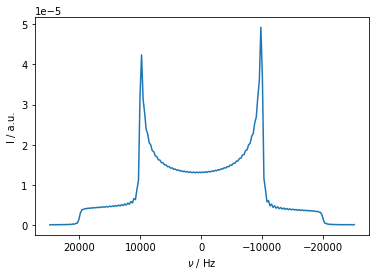

In [5]:
no_rlx.apod_pars['LB']=300
no_rlx.plot(FT=True,apodize=True)

### Spectrum with relaxation

In [6]:
L.clear_relax()
L.add_relax(Type='T1',i=1,T1=1e-7)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')

rlx=sl.Rho(rho0='Thermal',detect='13Cp')

Upi2*rlx
_=rlx.DetProp(seq,n=100)

State-space reduction: 16->2


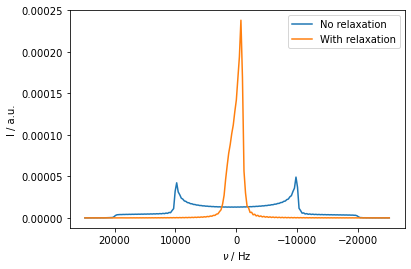

In [7]:
ax=no_rlx.plot(FT=True,apodize=True)
rlx.apod_pars['LB']=300
rlx.plot(FT=True,apodize=True,ax=ax)
_=ax.legend(('No relaxation','With relaxation'))

Then, we see that the Pake pattern collapses to the average of the two sides of the pattern. However, the average o of the pseudocontact shift is zero, and can be removed with moderate spinning, as shown below. Note that we change the powder average since the large number of angles are not required for MAS.

We re-initialize the experimental system (ex), since a number of settings get changed when adding MAS

State-space reduction: 16->2


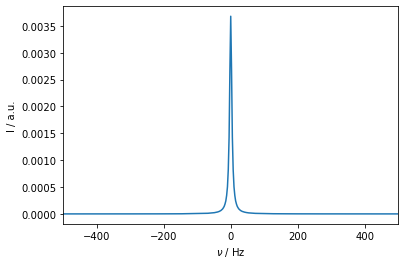

In [8]:
ex=sl.ExpSys(v0H=600,vr=5000,Nucs=['13C','e-'],T_K=100,LF=False,pwdavg=3)
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz)

L=ex.Liouvillian()
Upi2=L.Udelta('13C',np.pi/2,np.pi/2)
seq=L.Sequence()

rho=sl.Rho(rho0='Thermal',detect='13Cp')
Upi2*rho
rho.DetProp(seq,n=1024)

ax=rho.plot(FT=True,apodize=True)
_=ax.set_xlim([-500,500])

Then, if include magic-angle spinning, the influence of the pseudo-contact shift is removed. Similarly, if the system undergoes isotropic tumbling, the pseudo-contact shift vanishes. We allow the system to hop around a tetrahedral geometry to mimic this behavior.

State-space reduction: 64->8


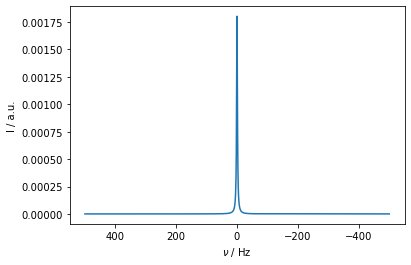

In [9]:
ex=sl.ExpSys(v0H=600,vr=0,Nucs=['13C','e-'],T_K=100,LF=False,pwdavg='alpha0beta0')
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz)

ex,kex=sl.Tools.SetupTumbling(ex,q=1,tc=1e-9) #This creates a system hopping around a tetrahedral geometry

L=sl.Liouvillian(ex,kex=kex)
L.add_relax(Type='T1',i=1,T1=1e-7)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')

Upi2=L.Udelta('13C',np.pi/2,np.pi/2)
seq=L.Sequence(Dt=1/1000)

rho=sl.Rho(rho0='Thermal',detect='13Cp')
Upi2*rho
rho.DetProp(seq,n=1024)

rho.plot(FT=True,apodize=True)
_=ax.set_xlim([-500,500])

## Pseudo-contact shift with g-anisotropy

Above, we saw that the pseudocontact shift vanishes with MAS or isotropic motion. However, if a g-anisotropy is included, then the pseudo-contact shift reappears.

However, note that it is not sufficient to add the g-anisotropy in the rotating frame. The g-anisotropy induces a pseudocontact shift because it changes the quantization axis of the electron away from the $z-$axis of the lab frame. This is only induced if the computation is performed in the lab frame. In this case, we need to be careful not to forget to downmix the resulting signal.

It is also important to correctly implement relaxation. Since the electron quantization axis is no longer along *z*, then $T_1$ and $T_2$ relaxation need to be applied along the correct axes. This requires using the `OS=True` option, along with the `Thermal=True` option for $T_1$ relaxation. We furthermore note that the electron $T_1$ must be faster than the tumbling: otherwise, the electron does not return to its quantization axis quickly enough to induce the pseudocontact shift.

### Pseudo-contact shift with anisotropic tumbling

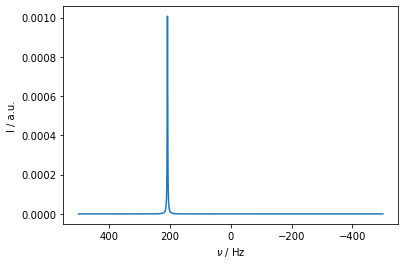

In [41]:
gxx,gyy,gzz=1,1,4
ex=sl.ExpSys(v0H=600,vr=0,Nucs=['13C','e-'],T_K=298,LF=True,pwdavg='alpha0beta0')
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=[0,0,0])

ex,kex=sl.Tools.SetupTumbling(ex,q=1,tc=5e-9) #This creates a system hopping around a tetrahedral geometry

L=sl.Liouvillian(ex,kex=kex)
L.add_relax(Type='T1',i=1,T1=1e-10,OS=True,Thermal=True)
L.add_relax(Type='T2',i=1,T2=1e-10,OS=True)

Upi2=L.Udelta('13C',np.pi/2,np.pi/2)
seq=L.Sequence(Dt=1/1000)

rho=sl.Rho(rho0='Thermal',detect='13Cp')
Upi2*rho
rho.DetProp(seq,n=1024)
rho.downmix()

ax=rho.plot(FT=True,apodize=True)

We can repeat the above calculation with decreasing temperature, just to verify that the PCS increases with decreasing temperature.

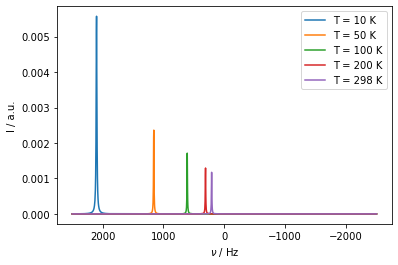

In [42]:
ax=plt.subplots()[1]
seq=L.Sequence(Dt=1/5000)

T=[10,50,100,200,298]
for T_K in T:
    L.expsys.T_K=T_K
    L.clear_cache()
    
    rho.clear()
    Upi2*rho
    rho.DetProp(seq,n=1024)
    rho.downmix()
    
    rho.plot(FT=True,apodize=True,ax=ax)
_=ax.legend([f'T = {T_K:.0f} K' for T_K in T])

Indeed, the expected temperature dependence is obtained. 

Note that the pseudocontact shift depends on the electron's polarization and quantization axis changing for different orientations. If the electron $T_1$ is longer than the rate of reorientation (from tumbling or MAS), the pseudocontact shift is reduced. We repeat the above calculation with a longer electron $T_1$

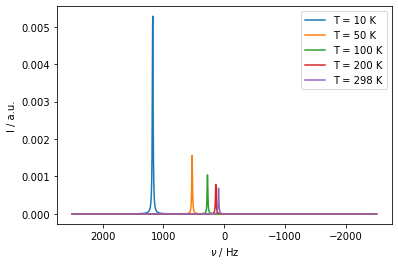

In [43]:
L.clear_relax()
L.add_relax(Type='T1',i=1,T1=1e-8,OS=True,Thermal=True)
L.add_relax(Type='T2',i=1,T2=1e-10,OS=True)

ax=plt.subplots()[1]
seq=L.Sequence(Dt=1/5000)

T=[10,50,100,200,298]
for T_K in T:
    L.expsys.T_K=T_K
    L.clear_cache()
    
    rho.clear()
    Upi2*rho
    rho.DetProp(seq,n=1024)
    rho.downmix()
    
    rho.plot(FT=True,apodize=True,ax=ax)
_=ax.legend([f'T = {T_K:.0f} K' for T_K in T])

The size of the PCS is reduces, since the electron does not recover to its thermal equilibrium quickly when hopping to a new orientation.

Note that a significant fraction of the PCS is obtained even if the electron is in the rotating frame; that is, most of the effect comes from changing electron polarization in different orientations, rather than change of the electron quantization axis. Note that we reset the relaxation times to the original values.

State-space reduction: 64->8
State-space reduction: 64->8
State-space reduction: 64->8
State-space reduction: 64->8
State-space reduction: 64->8


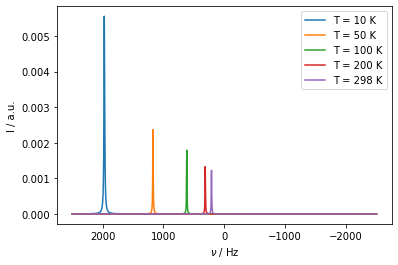

In [45]:
gxx,gyy,gzz=1,1,4
ex=sl.ExpSys(v0H=600,vr=0,Nucs=['13C','e-'],T_K=298,LF=False,pwdavg='alpha0beta0')
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=[0,0,0])

ex,kex=sl.Tools.SetupTumbling(ex,q=1,tc=5e-9) #This creates a system hopping around a tetrahedral geometry

L=sl.Liouvillian(ex,kex=kex)
L.add_relax(Type='T1',i=1,T1=1e-11,OS=True,Thermal=True)
L.add_relax(Type='T2',i=1,T2=1e-11,OS=True)

Upi2=L.Udelta('13C',np.pi/2,np.pi/2)

rho=sl.Rho(rho0='Thermal',detect='13Cp')

ax=plt.subplots()[1]
seq=L.Sequence(Dt=1/5000)

T=[10,50,100,200,298]
for T_K in T:
    L.expsys.T_K=T_K
    L.clear_cache()
    
    rho.clear()
    Upi2*rho
    rho.DetProp(seq,n=1024)
    rho.downmix()
    
    rho.plot(FT=True,apodize=True,ax=ax)
_=ax.legend([f'T = {T_K:.0f} K' for T_K in T])

State-space reduction: 64->8


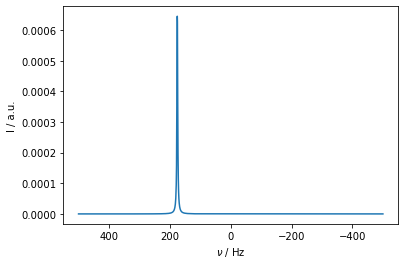

In [64]:
gxx,gyy,gzz=1,1,4
ex=sl.ExpSys(v0H=600,vr=0,Nucs=['13C','e-'],T_K=298,LF=False,pwdavg='alpha0beta0')
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=[0,0,0])

ex,kex=sl.Tools.SetupTumbling(ex,q=1,tc=5e-9) #This creates a system hopping around a tetrahedral geometry

L=sl.Liouvillian(ex,kex=kex)
L.add_relax(Type='T1',i=1,T1=1e-9,OS=True,Thermal=True)
L.add_relax(Type='T2',i=1,T2=1e-10,OS=True)

Upi2=L.Udelta('13C',np.pi/2,np.pi/2)
seq=L.Sequence(Dt=1/1000)

rho=sl.Rho(rho0='Thermal',detect='13Cp')
Upi2*rho
rho.DetProp(seq,n=1024)
rho.downmix()

ax=rho.plot(FT=True,apodize=True)

### Some junk below

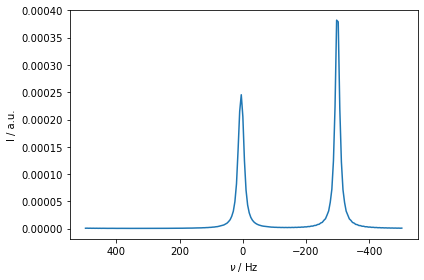

In [32]:
ex=sl.ExpSys(v0H=600,vr=0,Nucs=['13C','e-'],T_K=100,LF=False,pwdavg='alpha0beta0')
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz)

ex,kex=sl.Tools.SetupTumbling(ex,q=1,tc=1e-9) #This creates a system hopping around a tetrahedral geometry

L=sl.Liouvillian(ex,kex=kex)
L.add_relax(Type='T1',i=1,T1=1e-7)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')

Upi2=L.Udelta('13C',np.pi/2,np.pi/2)
seq=L.Sequence(Dt=1/1000)

rho=sl.Rho(rho0='Thermal',detect='13Cp')
Upi2*rho
rho.DetProp(seq,n=1024)
rho.downmix()

_=rho.plot(FT=True,apodize=True)

In the next example, we mimic isotropic tumbling with symmetric four-site hopping on a tetrahedral geometry. We include both an anisotropic g-tensor and dipolar hyperfine coupling. We have to include explicit relaxation on the electron to force the system to relax to thermal equilibrium (required for the residual coupling), although the main source of relaxation is the isotropic motion.

<AxesSubplot:xlabel='$\\nu$ / Hz', ylabel='I / a.u.'>

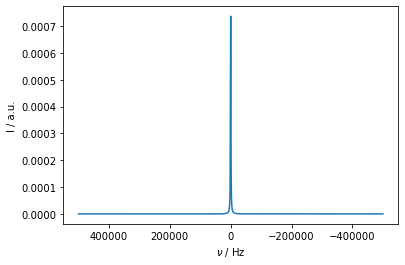

In [34]:
delta=2e4
g_euler=[0,2*np.pi/5,0]
gxx=gyy=gzz=2

ex=[]   #Since we have four states in exchange, we'll put them in a list
ex.append(sl.ExpSys(v0H=600,vr=0,Nucs=['13C','e-'],T_K=500,LF=True,pwdavg='alpha0beta0'))     #1-spin system at 600 MHz (14.1 T). LF=True : Lab Frame
ex[-1].set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex[-1].set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=g_euler)

phi_tetra=np.arccos(-1/3)
for k in range(3):
    ex.append(ex[0].copy())
    ex[-1].set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta,euler=[0,phi_tetra,k*2*np.pi/3])
    ex[-1].set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=[[0,phi_tetra,k*2*np.pi/3],g_euler])
    
L=sl.Liouvillian(*ex)
L.kex=sl.Tools.fourSite_sym(tc=1e-9)  #Four site symmetric exchange


L.add_relax(Type='T1',i=1,T1=1e-12)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')

U=L.U(Dt=1e-6)

rho=sl.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=4000)
rho()
rho.downmix()
rho.plot(FT=True,apodize=True)

<AxesSubplot:xlabel='$\\nu$ / Hz', ylabel='I / a.u.'>

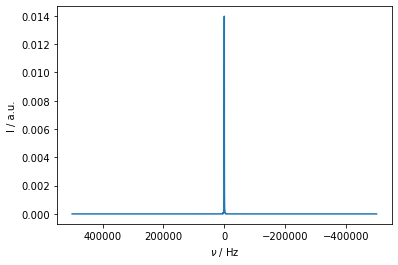

In [31]:
gxx,gyy,gzz=1,1,4
phi_tetra=np.arccos(-1/3)
for k,ex0 in enumerate(ex):
    if k==0:
        ex0.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=[[0,0,0],g_euler])
    else:
        ex0.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=[[0,phi_tetra,(k-1)*2*np.pi/3],g_euler])
    
L=sl.Liouvillian(ex)
L.kex=sl.Tools.fourSite_sym(tc=1e-9)  #Four site symmetric exchange

L.add_relax(Type='T1',i=1,T1=1e-12,OS=True,Thermal=True)
L.add_relax(Type='T2',i=1,T2=1e-12,OS=True)
# L.add_relax(Type='recovery')

U=L.U(Dt=1e-6)

rho=sl.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=4000)
rho.downmix()
rho.plot(FT=True,apodize=True)

### Verify temperature dependence
We will re-run the above simulation, but as a function of temperature to confirm its dependence on the temperature

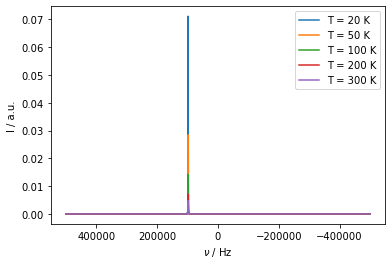

In [31]:
ax=plt.subplots(1,1)[1]
T0=[20,50,100,200,300]
for T in T0:
    L.expsys.T_K=T
    L.clear_relax()
    L.add_relax(Type='T1',i=1,T1=1e-12,OS=True,Thermal=True)  #Add T1 relaxation (1 ns). 
    L.add_relax(Type='T2',i=1,T2=1e-12,OS=True) #Add T2 relaxation (ensure physical system)
    
    U=L.U(Dt=1e-6)

    rho=sl.Rho(rho0='13Cx',detect='13Cp')
    rho.DetProp(U,n=4000)
    rho()
    rho.downmix()
    rho.plot(ax=ax,FT=True,apodize=True)
# ax.set_xlim([200000,-20000])
ax.legend([f'T = {T} K' for T in T0])

### Is the g-tensor anisotropy required?
We'll re-run the above calculation with an isotropic g-tensor to see what impact this has

<IPython.core.display.Javascript object>


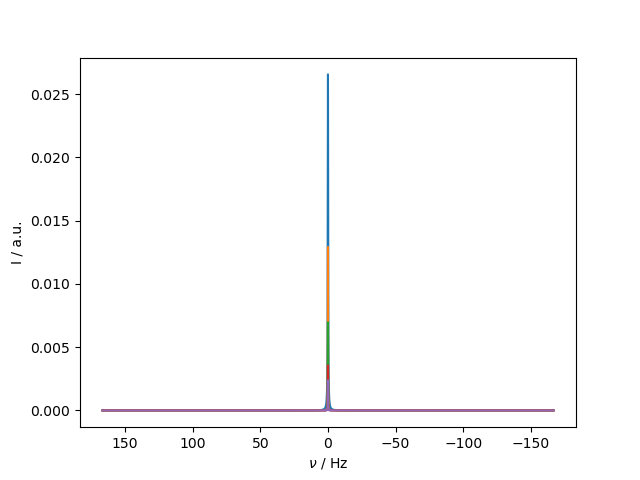

In [19]:
for ex0 in ex:
    ex0.set_inter('g',i=1,gxx=2,gyy=2,gzz=2)  #Set isotropic g-tensor

#We have to re-build the Liouvillian after editing interactions
L=RS.Liouvillian([ex[k] for k in [0,1,2,3]])
L.kex=RS.Tools.fourSite_sym(tc=1e-9)  #Four site symmetric exchange


ax=plt.subplots(1,1)[1]
T0=[10,50,100,200,300]
for T in T0:
    L.expsys.T_K=T
    L.clear_relax()
    L.add_relax(Type='T1',i=1,T1=1e-12)  #Add T1 relaxation (1 ns). 
    L.add_relax(Type='T2',i=1,T2=1e-12) #Add T2 relaxation (ensure physical system)
    L.add_relax(Type='recovery')
    
    U=L.U(Dt=3e-3)

    rho=RS.Rho(rho0='13Cx',detect='13Cp')
    rho.DetProp(U,n=4000)
    rho()
    rho.downmix()
    rho.plot(ax=ax,FT=True,apodize=True)

The effect has vanished, confirming that we do require anistropy of the g-tensor to tilt the electron quantization axis away from the magnetic field's $z$-axis

## Pseudocontact Shift under MAS

In [74]:
delta=2e4
gxx,gyy,gzz=1,1,4
g_euler=[0,2*np.pi/5,0]
g_euler=[0,0,0]

ex=RS.ExpSys(v0H=600,vr=10000,Nucs=['13C','e-'],T_K=50,LF=True,pwdavg=RS.PowderAvg(q=8))
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=g_euler)

L=RS.Liouvillian(ex)

L.add_relax(Type='T1',i=1,T1=1e-9)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')

U=L.U()**10

rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=100)
rho.downmix()


NameError: name 'RS' is not defined

<IPython.core.display.Javascript object>


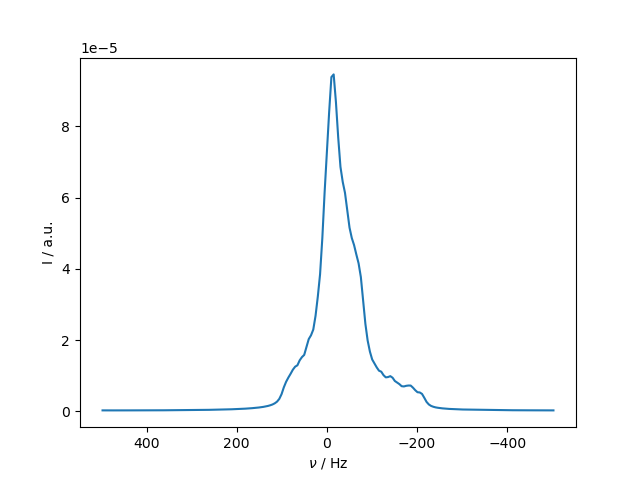

<AxesSubplot:xlabel='$\\nu$ / Hz', ylabel='I / a.u.'>

In [4]:
rho.plot(FT=True,apodize=True)

Below, we test the impact of removing the g-tensor anisotropy, to determine if MAS can spin out the pseudocontact shift when the electron quantization axis is along $z$.

We can also verify that the effect is temperature dependent, by observing the narrowing of the lineshape upon temperature increase

<IPython.core.display.Javascript object>


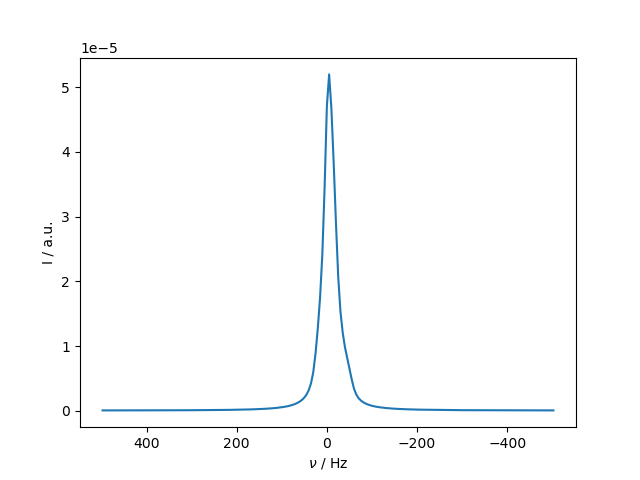

<AxesSubplot:xlabel='$\\nu$ / Hz', ylabel='I / a.u.'>

In [27]:
ex=RS.ExpSys(v0H=600,vr=10000,Nucs=['13C','e-'],T_K=200,LF=True,pwdavg=RS.PowderAvg(q=8))
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=1,gyy=1,gzz=4,euler=g_euler)

L=RS.Liouvillian(ex)

L.add_relax(Type='T1',i=1,T1=1e-9)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')

U=L.U()**10

rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=100)
rho.downmix()
rho.plot(FT=True,apodize=True)

Finally, we note that the pseudocontact shift itself, if modulated by exchange, can result in relaxation. Here, we investigate its influence on the $R_{1\rho}$.

Note we have to perform this experiment in a mixed rotating (nucleus) / lab (electron) frame, to allow application of the RF field to the nucleus while retaining the electron tilting in the lab frame of the electron.

In [3]:
RS.Defaults['parallel']=False
delta=2e4
gxx,gyy,gzz=1,1,4
g_euler=[0,2*np.pi/5,0]

ex0=RS.ExpSys(v0H=600,vr=40000,Nucs=['13C','e-'],T_K=200,LF=[False,True],pwdavg=RS.PowderAvg(q=3))
ex0.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex0.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=g_euler)

ex1=ex0.copy()
ex1.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta,euler=[0,np.pi/4,0])

L=RS.Liouvillian((ex0,ex1))

L.kex=RS.Tools.twoSite_kex(tc=5e-6)
L.add_relax(Type='T1',i=1,T1=1e-9)
L.add_relax(Type='T2',i=1,T2=1e-12)


seq=L.Sequence()
seq.add_channel('13C',v1=35000)

#First calculate without exchange
U=seq.U()**100

rho=RS.Rho(rho0='13Cx',detect='13Cx')
rho.DetProp(U,n=300)

#Now add thermal polarization
L.add_relax(Type='recovery')
U=seq.U()**100

rho1=RS.Rho(rho0='13Cx',detect=f'{L.expsys.Peq[0]/2}*13Cx')
_=rho1.DetProp(U,n=300)


#Finally, lower the temperature
L.expsys.T_K=50
L.clear_relax()
L.add_relax(Type='T1',i=1,T1=1e-9)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')
U=seq.U()**100

rho2=RS.Rho(rho0='13Cx',detect=f'{L.expsys.Peq[0]/2}*13Cx')
_=rho2.DetProp(U,n=300)

<IPython.core.display.Javascript object>


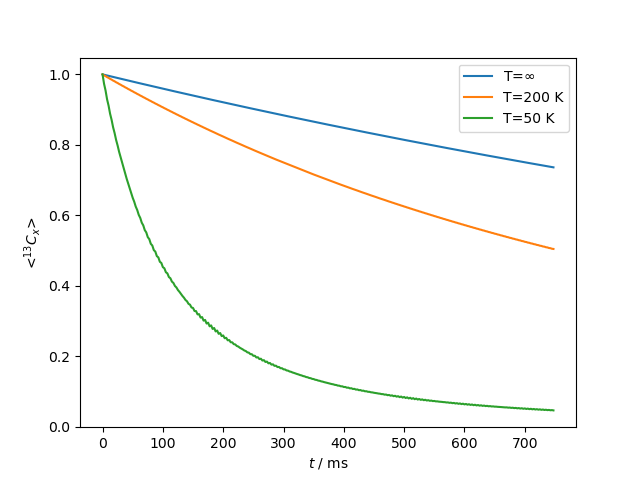

In [4]:
ax=rho.plot()
rho1.plot(ax=ax)
rho2.plot(ax=ax)
_=ax.legend([r'T=$\infty$','T=200 K','T=50 K'])

Some relaxation occurs without the exchange on the pseudocontact shift, possibly originating with the electron relaxation or some residual hyperfine coupling in exchange. However, when we add polarization to the electron, we see a distinct increase in the $R_{1\rho}$ relaxation rate constant, which is due to exchange modulation of the pseudocontact shift.

Note that this effect does *NOT* depend heavily on the presence of an anistropic g-tensor, as we demonstrate below by removing the anisotropy, and nonetheless obtain similar results.

In [5]:
RS.Defaults['parallel']=False
delta=2e4
gxx,gyy,gzz=2,2,2
g_euler=[0,2*np.pi/5,0]

ex0=RS.ExpSys(v0H=600,vr=40000,Nucs=['13C','e-'],T_K=200,LF=[False,True],pwdavg=RS.PowderAvg(q=3))
ex0.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex0.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=g_euler)

ex1=ex0.copy()
ex1.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta,euler=[0,np.pi/4,0])

L=RS.Liouvillian((ex0,ex1))

L.kex=RS.Tools.twoSite_kex(tc=5e-6)
L.add_relax(Type='T1',i=1,T1=1e-9)
L.add_relax(Type='T2',i=1,T2=1e-12)


seq=L.Sequence()
seq.add_channel('13C',v1=35000)

#First calculate without exchange
U=seq.U()**100

rho=RS.Rho(rho0='13Cx',detect='13Cx')
rho.DetProp(U,n=300)

#Now add thermal polarization
L.add_relax(Type='recovery')
U=seq.U()**100

rho1=RS.Rho(rho0='13Cx',detect=f'{L.expsys.Peq[0]/2}*13Cx')
_=rho1.DetProp(U,n=300)


#Finally, lower the temperature
L.expsys.T_K=50
L.clear_relax()
L.add_relax(Type='T1',i=1,T1=1e-9)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')
U=seq.U()**100

rho2=RS.Rho(rho0='13Cx',detect=f'{L.expsys.Peq[0]/2}*13Cx')
_=rho2.DetProp(U,n=300)

<IPython.core.display.Javascript object>


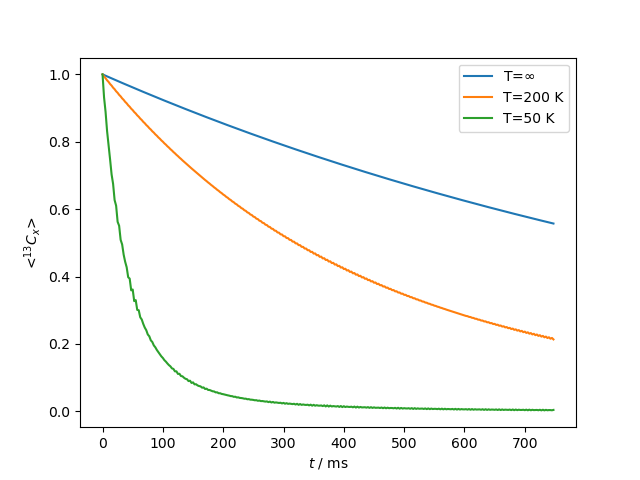

In [6]:
ax=rho.plot()
rho1.plot(ax=ax)
rho2.plot(ax=ax)
_=ax.legend([r'T=$\infty$','T=200 K','T=50 K'])

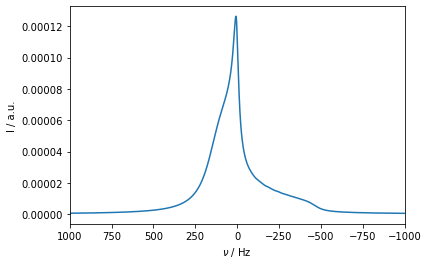

In [76]:
delta=sl.Tools.dipole_coupling(1,'e-','13C')    #10 Angstroms from electron
pwd=sl.PowderAvg(q=4)
ex=sl.ExpSys(v0H=600,Nucs=['13C','e-'],vr=6000,LF=True,T_K=200,pwdavg=pwd,n_gamma=30)  #Electron-nuclear system
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=1,gyy=1,gzz=4)
    
L=sl.Liouvillian(ex)        #Generate a Liouvillian

L.add_relax('T1',i=1,T1=1e-7,OS=True,Thermal=True)  #1 microsecond T1
L.add_relax('T2',i=1,T2=1e-7,OS=True) #1 ns T2, required for physical system when T1 is present

seq=L.Sequence() #Generate an empty sequence

rho=sl.Rho('13Cx','13Cp')  #Generate initial state, detection operator
rho.DetProp(seq,n=8000,n_per_seq=1) #Propagate the system
rho.downmix()
ax=rho.plot(FT=True,apodize=True) #Plot the results into the same axis
_=ax.set_xlim([1500,-1500])